In [198]:
import numpy as np
from scipy.optimize import curve_fit
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [199]:
summary_statistics = pd.DataFrame()
# Add columns for SSE1 and SSE2
summary_statistics['SSE1'] = np.nan
summary_statistics['SSE2'] = np.nan

In [200]:
tasks = [
    "square",
    "nut_assembly",
    "three_piece_assembly",
    "kitchen",
    "coffee",
    "stack_three",
    "Cumulative_Data",
]
trial_count = 30

Parameters for task square: [-45.83135873   0.97421068  11.32216409  -2.71064877]
Performance with 0 noise: 42
SSE: 267.62280160734076


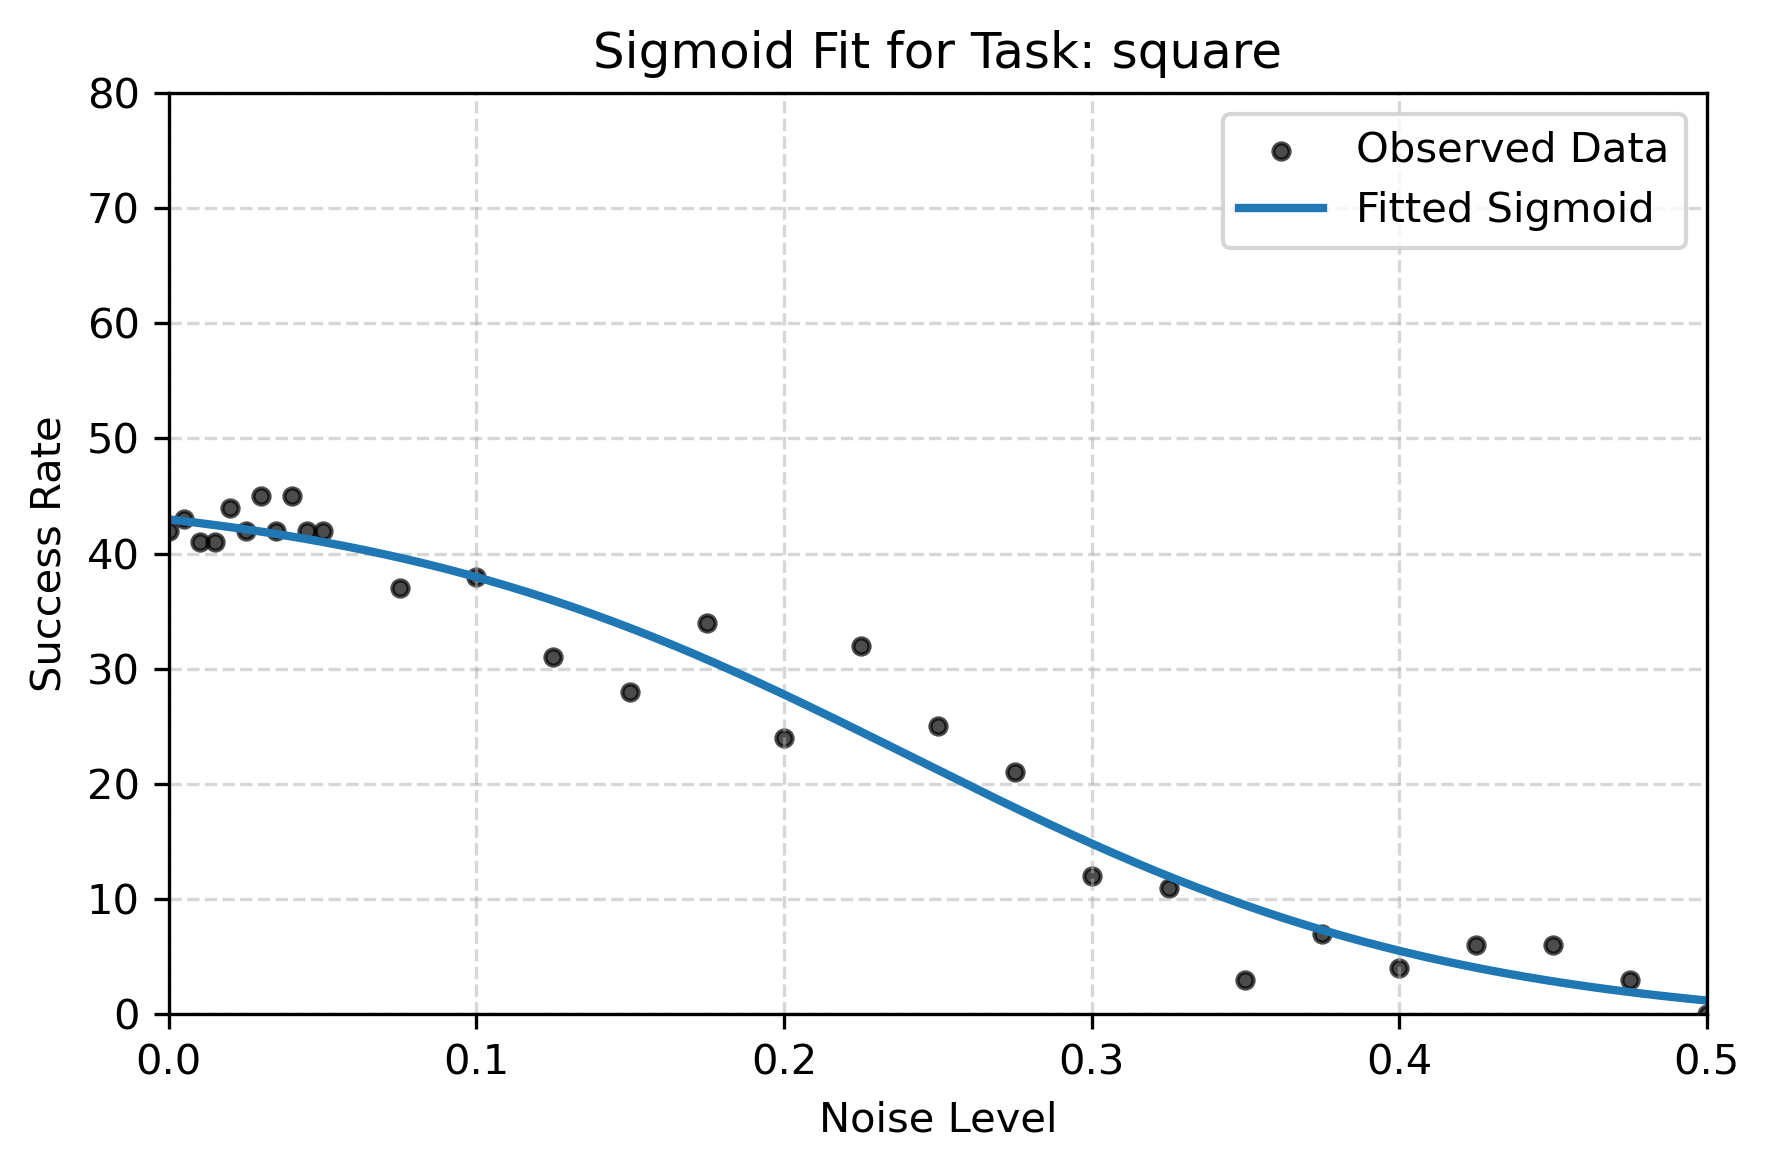

Parameters for task nut_assembly: [-54.75704451   1.00332824  20.30502194  -3.62992183]
Performance with 0 noise: 53
SSE: 279.67001179611674


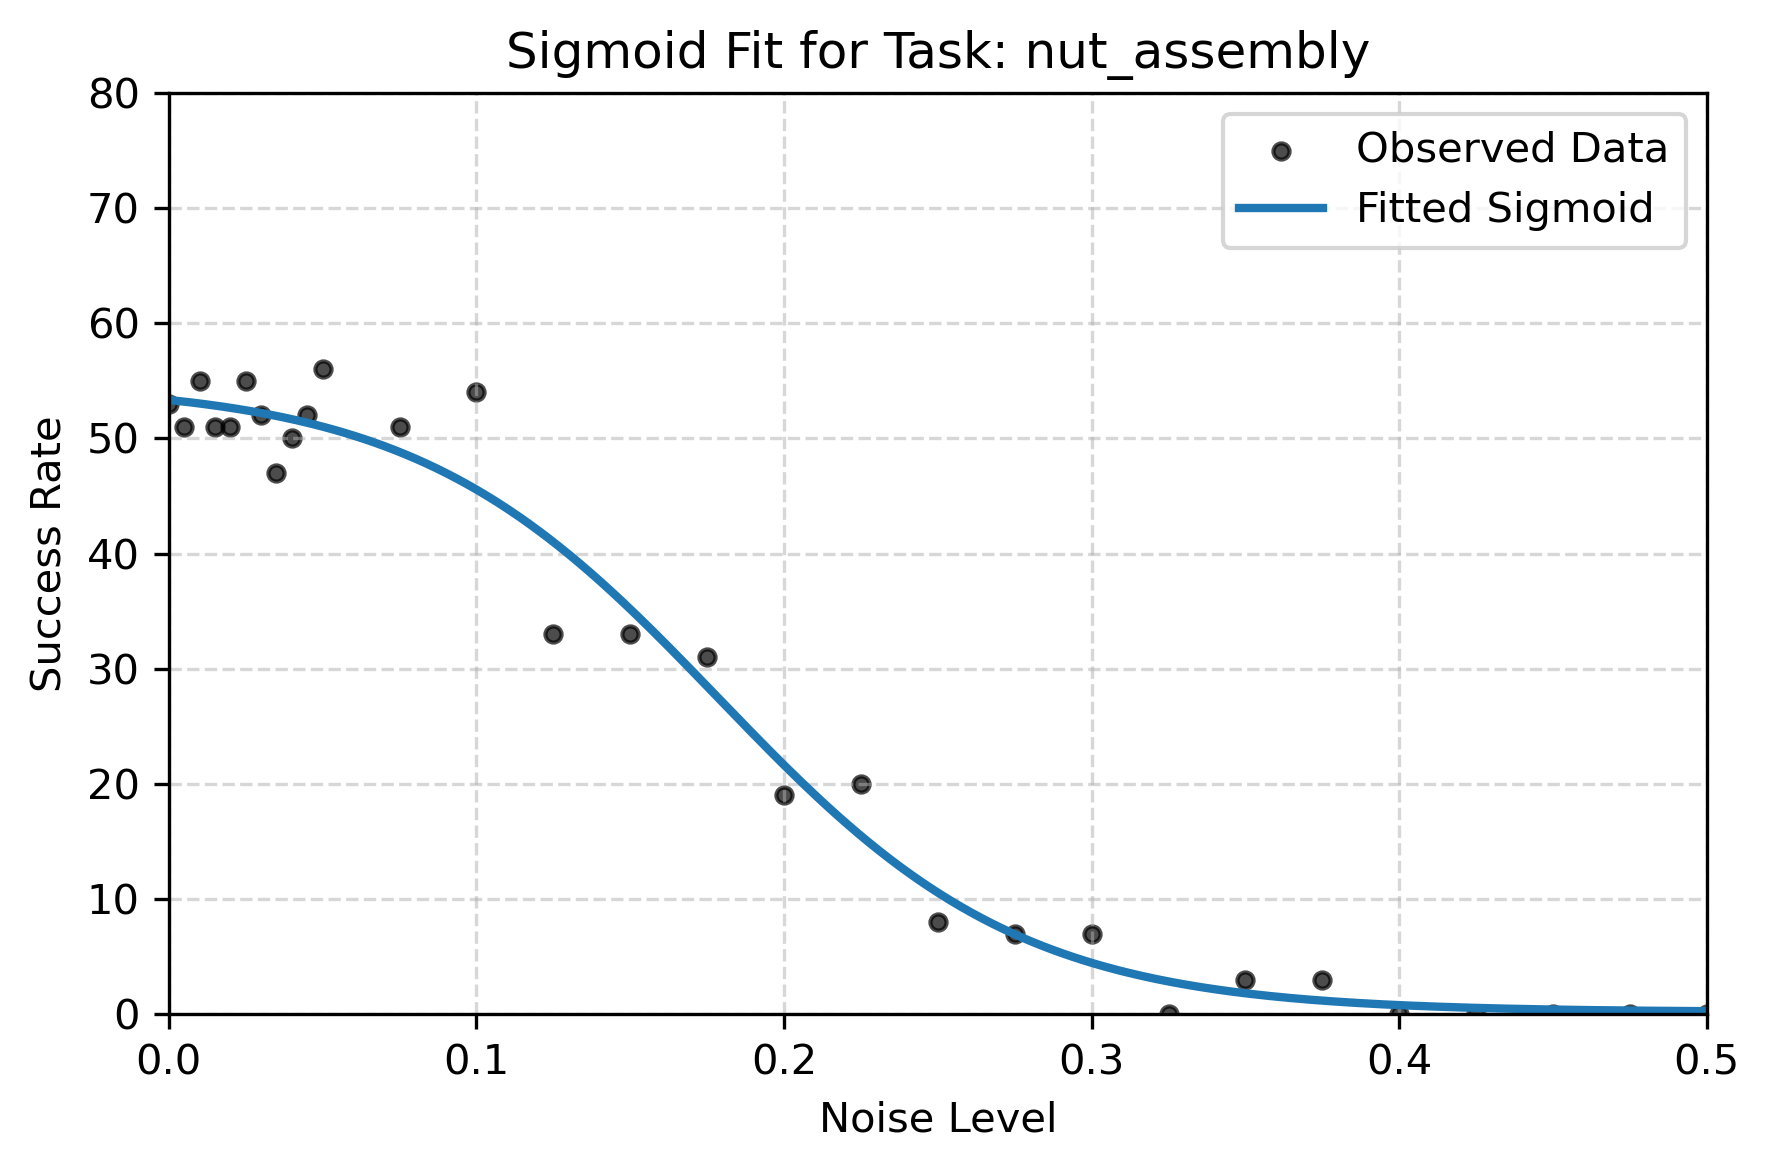

Parameters for task three_piece_assembly: [-26.30720954   1.02556998  19.2958359   -3.43661591]
Performance with 0 noise: 23
SSE: 145.06772798224358


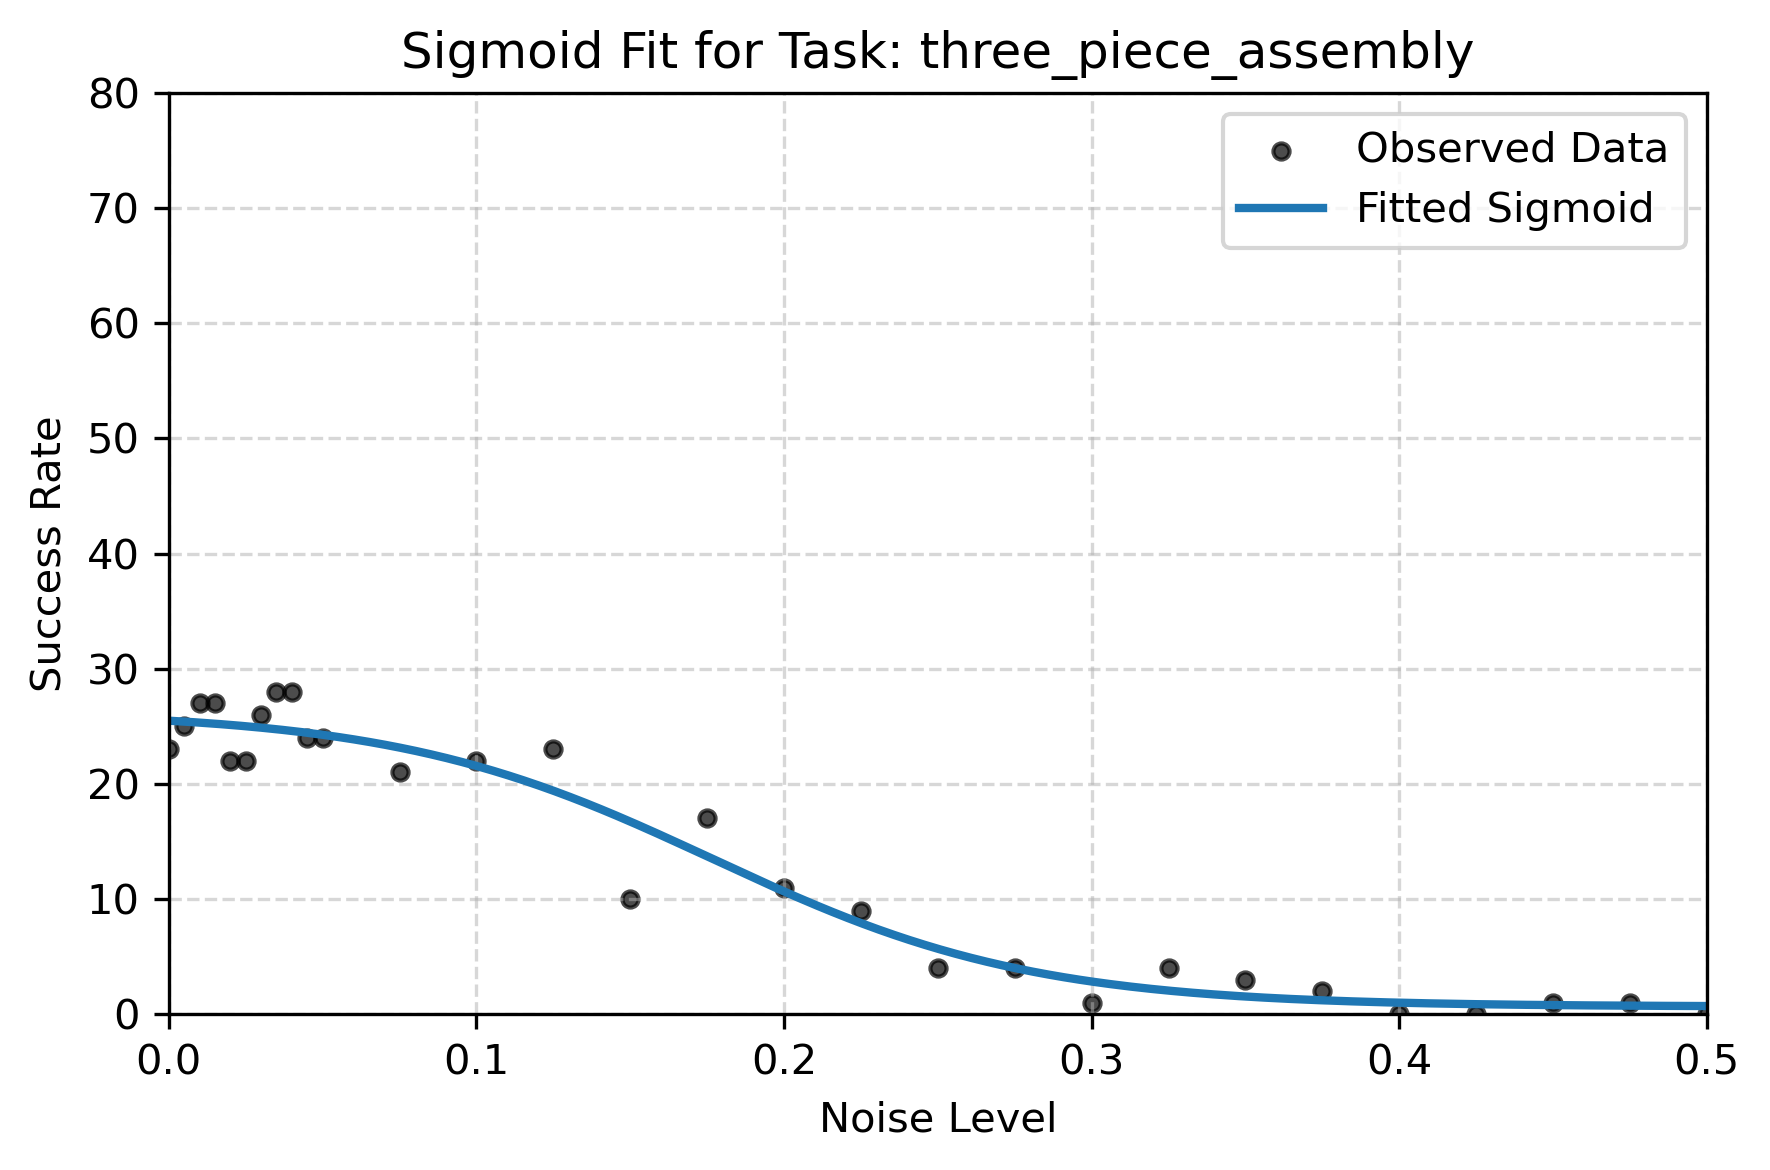

Parameters for task kitchen: [-53.08434461   0.99533897  16.50924791  -3.33916615]
Performance with 0 noise: 52
SSE: 361.9060331874671


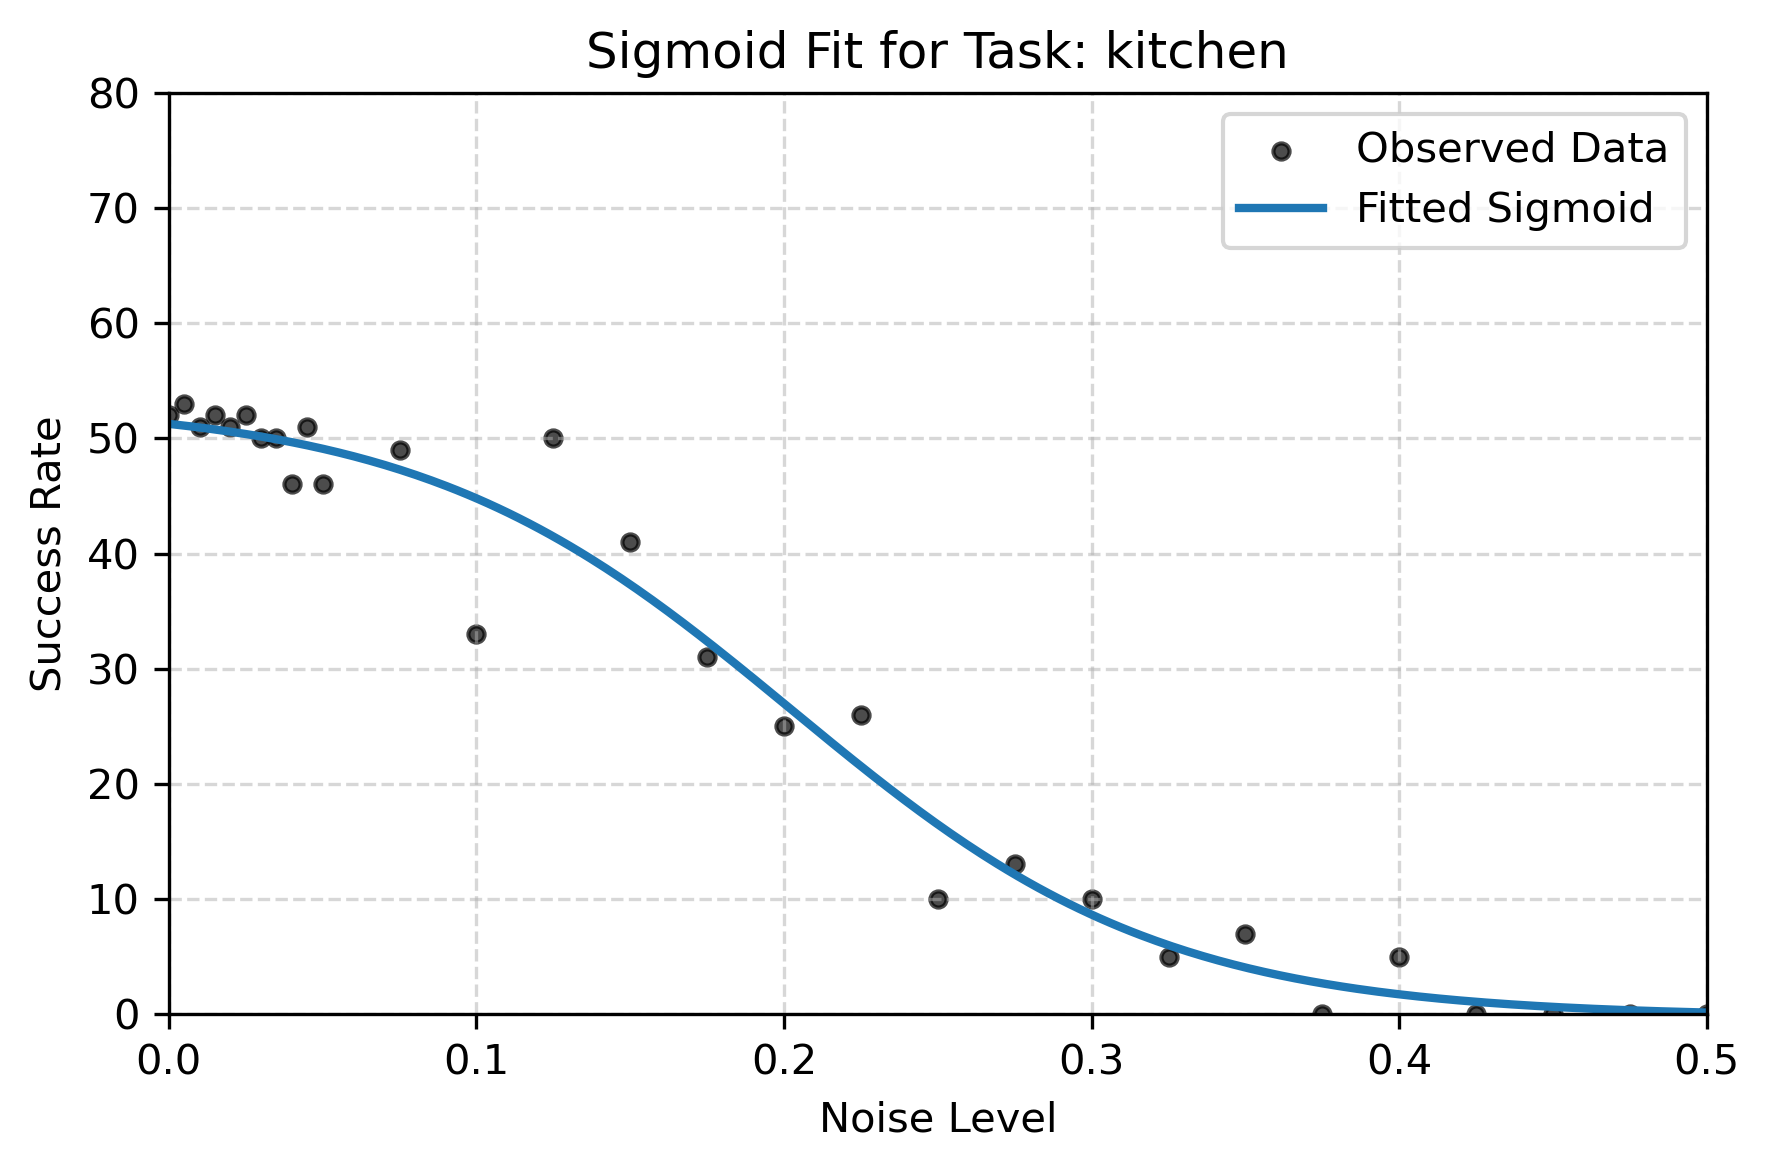

Parameters for task coffee: [-67.15032877   0.99359083  20.02083817  -3.13311204]
Performance with 0 noise: 65
SSE: 354.3258083440832


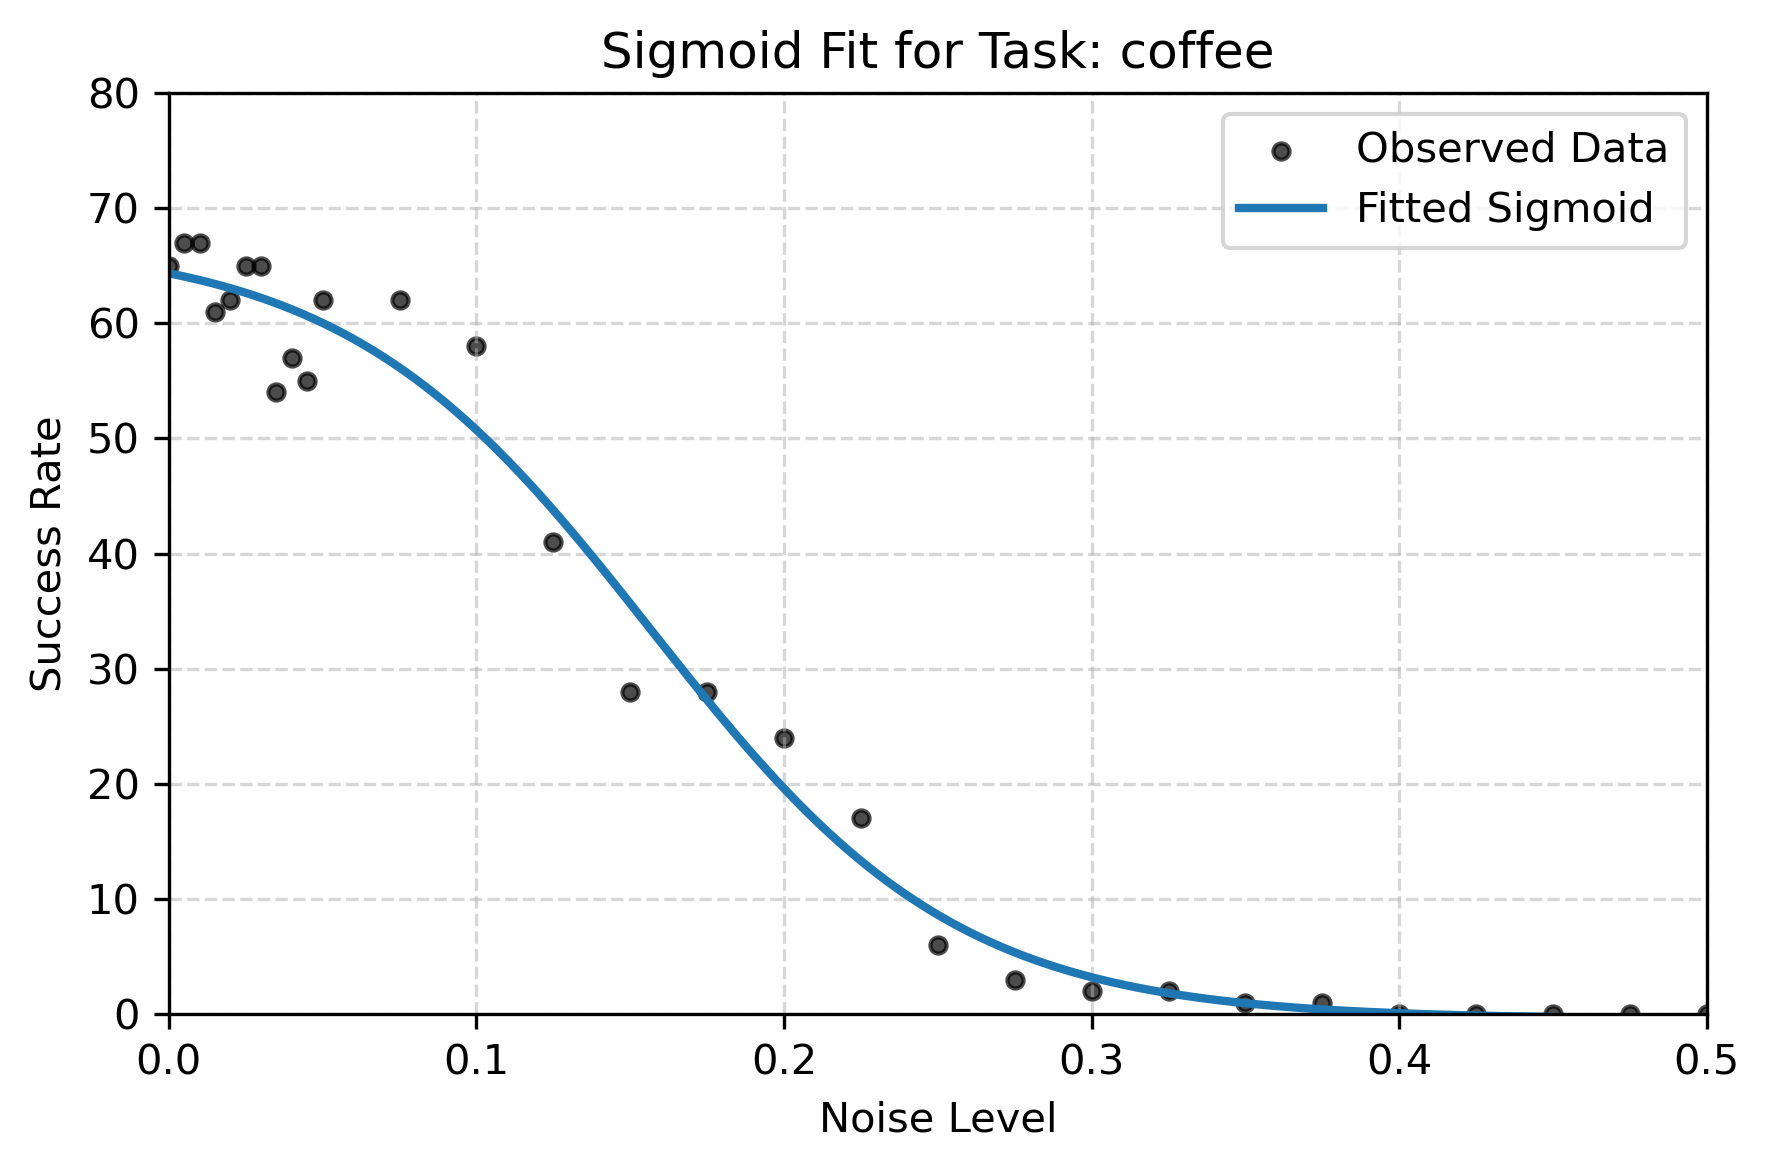

Parameters for task stack_three: [-72.21069965   1.0401792   18.9806884   -3.57712528]
Performance with 0 noise: 68
SSE: 336.95791414158595


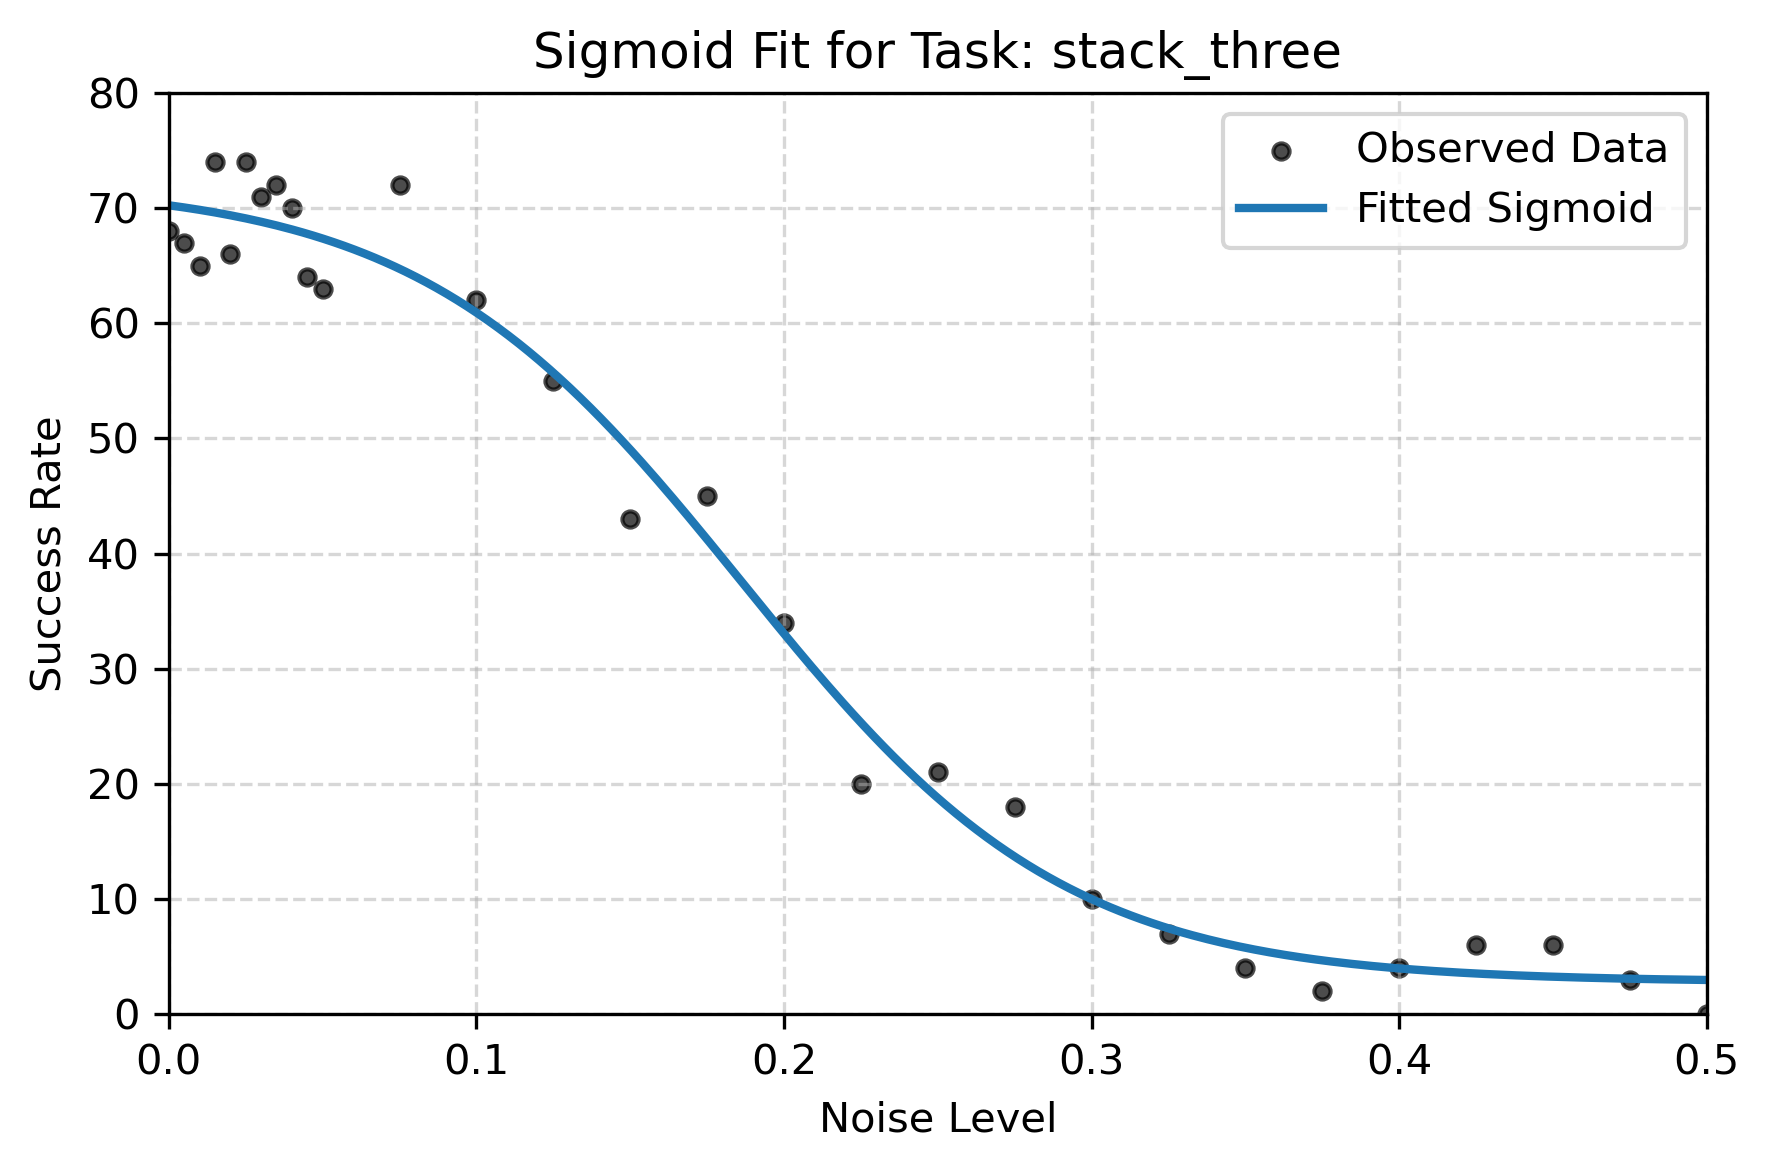

Parameters for task Cumulative_Data: [-54.06592499   1.0098287   16.35851451  -3.00944443]
Performance with 0 noise: 50.5
SSE: 48.07058531912567


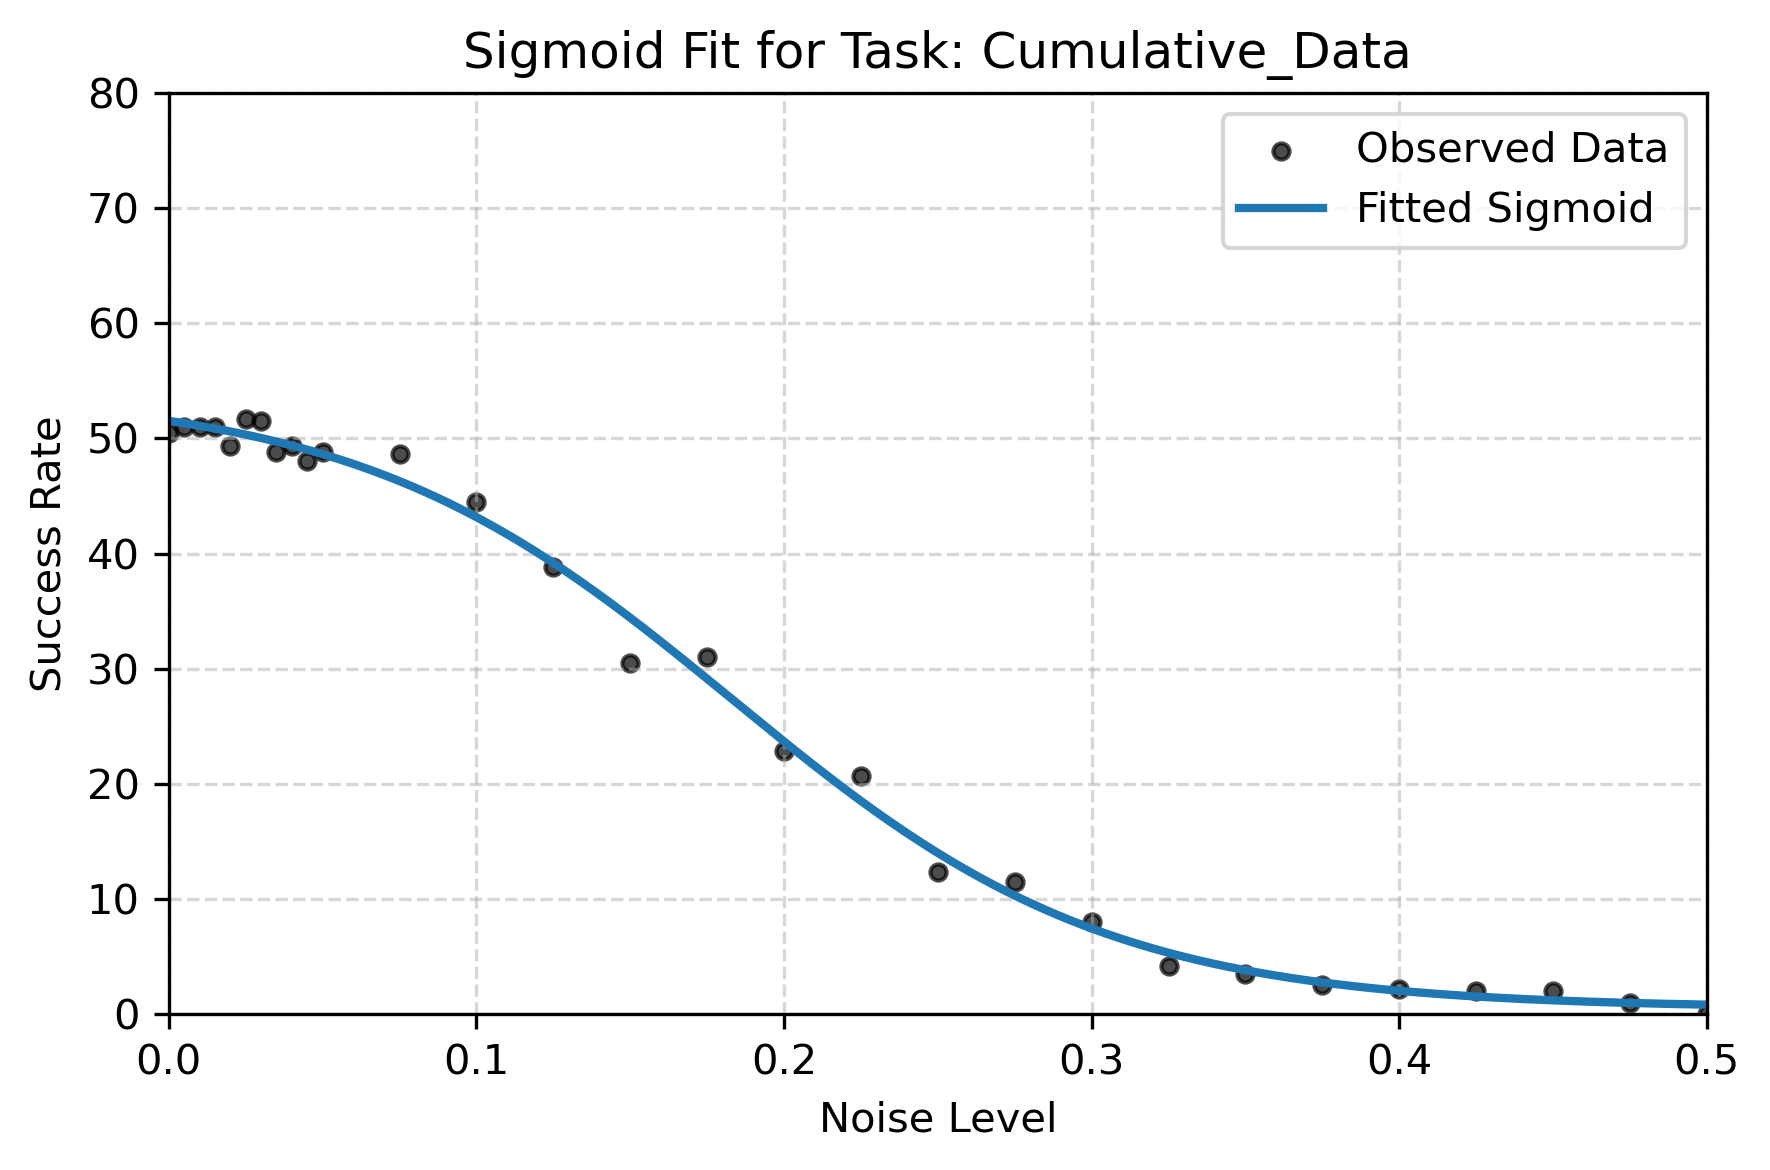

In [201]:
learned_parameters = []

# Loop through each task

for task in tasks:
    data_dir = os.path.expanduser("~/MimicGenProject/MimicGenProject/data")
    output_csv = os.path.join(data_dir, f"{task}.csv")
    data = pd.read_csv(output_csv)
    data = data[data["noise"] < 1.0]

    # Your data
    x_data = data["noise"].to_numpy()
    y_data = data["success_rate"].to_numpy() if task != "Cumulative_Data" else data["avg accuracy"].to_numpy()

    # Your sigmoid function
    def custom_sigmoid(x, A, B, C, D):
        return A * (1/(B + np.exp(-C * x - D)) - 1)

    # Initial parameter guesses
    initial_guess = [-52.8, 1.0, 17.6, -3.32]

    param_bounds = (
    [-100, 0.01, 0.01, -10],   # Lower bounds: [A, B, C, D, E]
    [100, 10, 100, 10]          # Upper bounds
    )

    # Fit the model
    params_opt, params_cov = curve_fit(custom_sigmoid, x_data, y_data, p0=initial_guess, bounds=param_bounds)
    
    if task != "Cumulative_Data":
        # Add params_opt copy but with f(0) added to the list
        learned_parameters.append([y_data[0], params_opt[0], params_opt[1], params_opt[2], params_opt[3]])

    print(f"Parameters for task {task}: {str(params_opt)}")
    print(f"Performance with 0 noise: {y_data[0]}")
    SSE = np.sum((y_data - custom_sigmoid(x_data, *params_opt))**2)
    print(f"SSE: {SSE}")
    # Put the SSE in the summary_statistics DataFrame
    summary_statistics.loc[task, 'SSE1'] = SSE
    # Add RMSE and MAE to summary_statistics
    RMSE = np.sqrt(SSE / len(x_data))
    MAE = np.mean(np.abs(y_data - custom_sigmoid(x_data, *params_opt)))
    summary_statistics.loc[task, 'RMSE1'] = RMSE
    summary_statistics.loc[task, 'MAE1'] = MAE
    # Add R^2 to summary_statistics
    y_mean = np.mean(y_data)
    SS_total = np.sum((y_data - y_mean)**2)
    SS_residual = np.sum((y_data - custom_sigmoid(x_data, *params_opt))**2)
    R_squared = 1 - (SS_residual / SS_total)
    summary_statistics.loc[task, 'R_squared1'] = R_squared
    
    # Plot
    plt.figure(figsize=(6, 4), dpi=300)
    plt.scatter(x_data, y_data, label='Observed Data', color='black', s=15, alpha=0.7)

    x_fit = np.linspace(min(x_data), max(x_data), 300)
    y_fit = custom_sigmoid(x_fit, *params_opt)
    plt.plot(x_fit, y_fit, label='Fitted Sigmoid', linewidth=2)

    # Labels and styling
    plt.title(f"Sigmoid Fit for Task: {task}", fontsize=12)
    plt.xlabel("Noise Level", fontsize=10)
    plt.ylabel("Success Rate", fontsize=10)
    plt.ylim(0,80)
    plt.xlim(0,.5)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    # Optional: save figure
    # fig_path = os.path.join(data_dir, f"{task}_fit.png")
    # plt.savefig(fig_path, dpi=300)

    plt.show()

In [ ]:
def fit_parameter_models(task_params):
    data = np.array(task_params)
    P_vals = data[:, 0]  # Assumed equal to A and D
    B_vals = data[:, 2]
    C_vals = data[:, 3]
    E_vals = data[:, 4]

    # Fit linear regressions: param = a*P + b
    def fit_linear(y):
        model = LinearRegression()
        model.fit(P_vals.reshape(-1, 1), y)
        return model.coef_[0], model.intercept_

    b1, b0 = fit_linear(B_vals)
    c1, c0 = fit_linear(C_vals)
    e1, e0 = fit_linear(E_vals)

    print(f"Fitted parameter models:")
    print(f"B(P) = {b0:.4f} + {b1:.4f} * P")
    print(f"C(P) = {c0:.4f} + {c1:.4f} * P")
    print(f"E(P) = {e0:.4f} + {e1:.4f} * P")

    # Return a predictive sigmoid function
    def predicted_sigmoid(x, P):
        A = -P
        B = b0 + b1 * P
        C = c0 + c1 * P
        E = e0 + e1 * P
        return A / (B + np.exp(-C * x - E)) + A + 2*P

    return predicted_sigmoid

In [203]:
print(learned_parameters)

[[42, -45.83135872965051, 0.9742106754562609, 11.322164087488755, -2.710648769408732], [53, -54.757044509427814, 1.0033282369944372, 20.305021942473623, -3.629921834122213], [23, -26.30720954430043, 1.0255699849642825, 19.295835900861253, -3.436615906499969], [52, -53.084344609565804, 0.9953389729634623, 16.509247912282977, -3.339166152996724], [65, -67.15032877131353, 0.9935908330576871, 20.02083816642047, -3.133112044913083], [68, -72.21069965369502, 1.0401791966472451, 18.98068839758799, -3.5771252817783274]]


Fitted parameter models:
B(P) = 1.0387 + -0.0010 * P
C(P) = 17.6122 + -0.0162 * P
E(P) = -3.1988 + -0.0015 * P


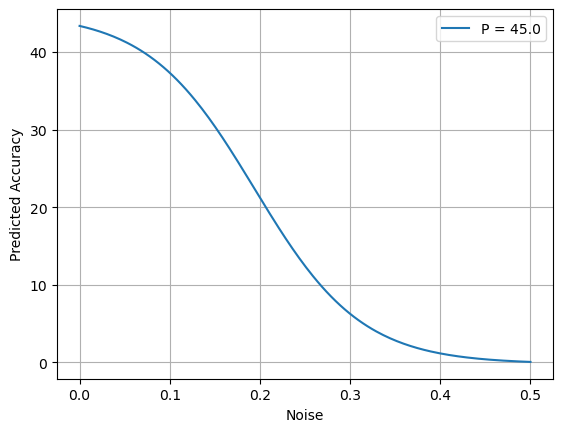

In [204]:
sigmoid_fn = fit_parameter_models(learned_parameters[:3])

# Plot for a given P
x = np.linspace(0, 0.5, 200)
P = 45.0
y = sigmoid_fn(x, P)

plt.plot(x, y, label=f"P = {P}")
plt.xlabel("Noise")
plt.ylabel("Predicted Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Fitted parameter models:
B(P) = 1.0006 + 0.0001 * P
C(P) = 15.0856 + 0.0525 * P
E(P) = -3.1341 + -0.0034 * P
SSE: 1121.9439116305841


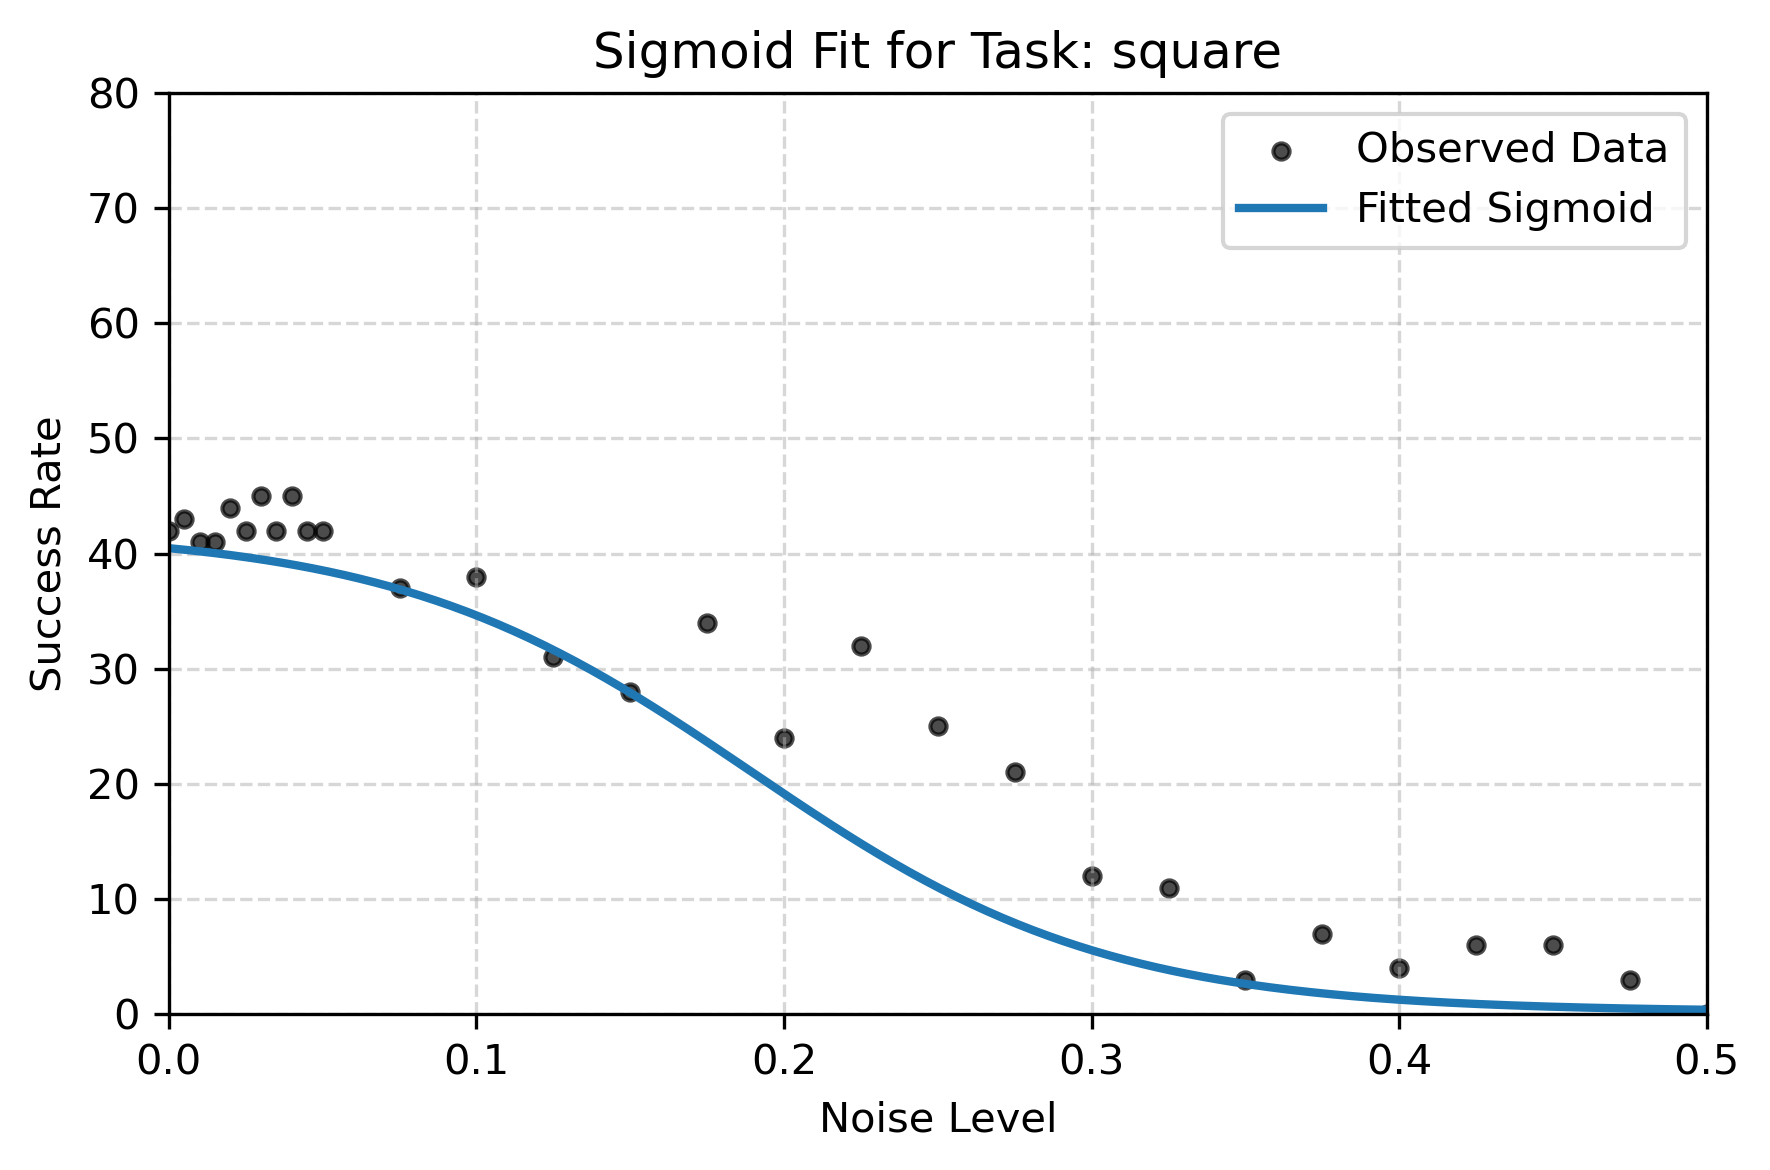

Fitted parameter models:
B(P) = 1.0006 + 0.0001 * P
C(P) = 15.0856 + 0.0525 * P
E(P) = -3.1341 + -0.0034 * P
SSE: 373.9393011002331


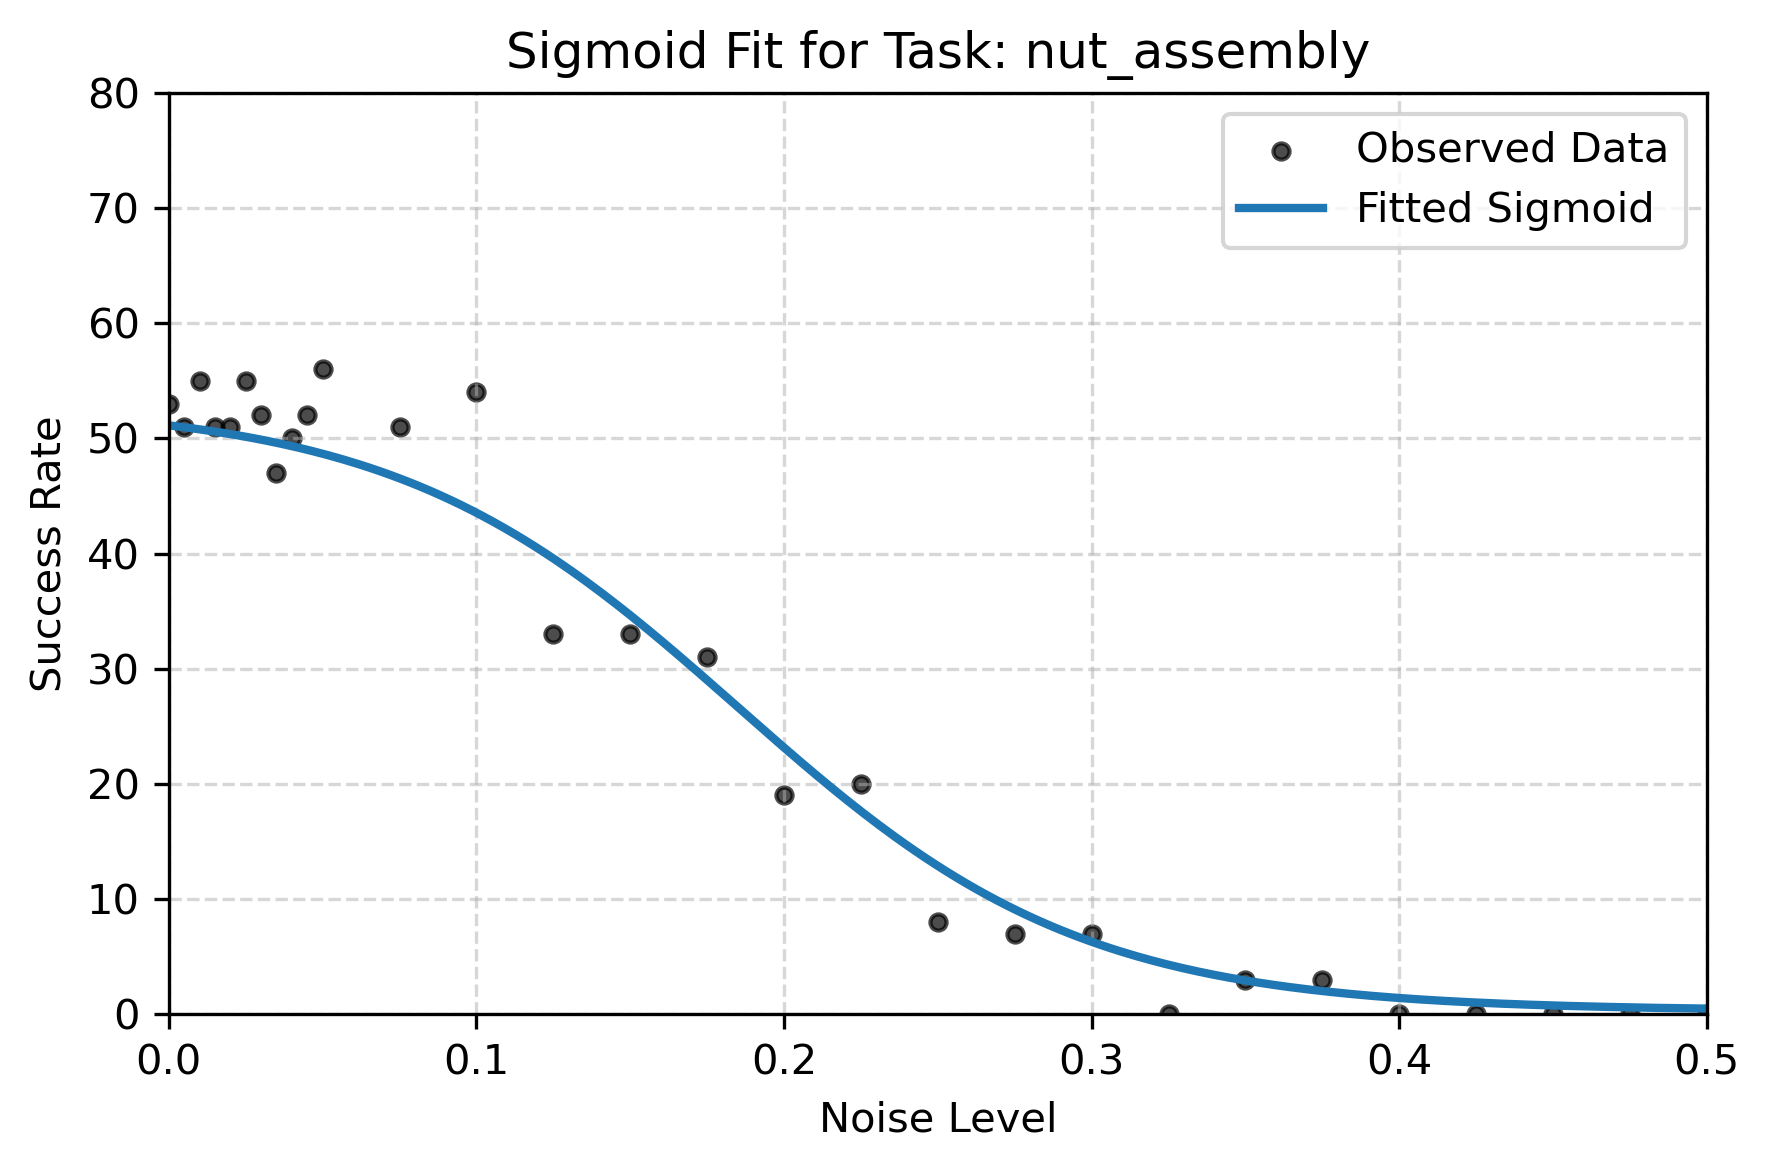

Fitted parameter models:
B(P) = 1.0006 + 0.0001 * P
C(P) = 15.0856 + 0.0525 * P
E(P) = -3.1341 + -0.0034 * P
SSE: 289.50656878516867


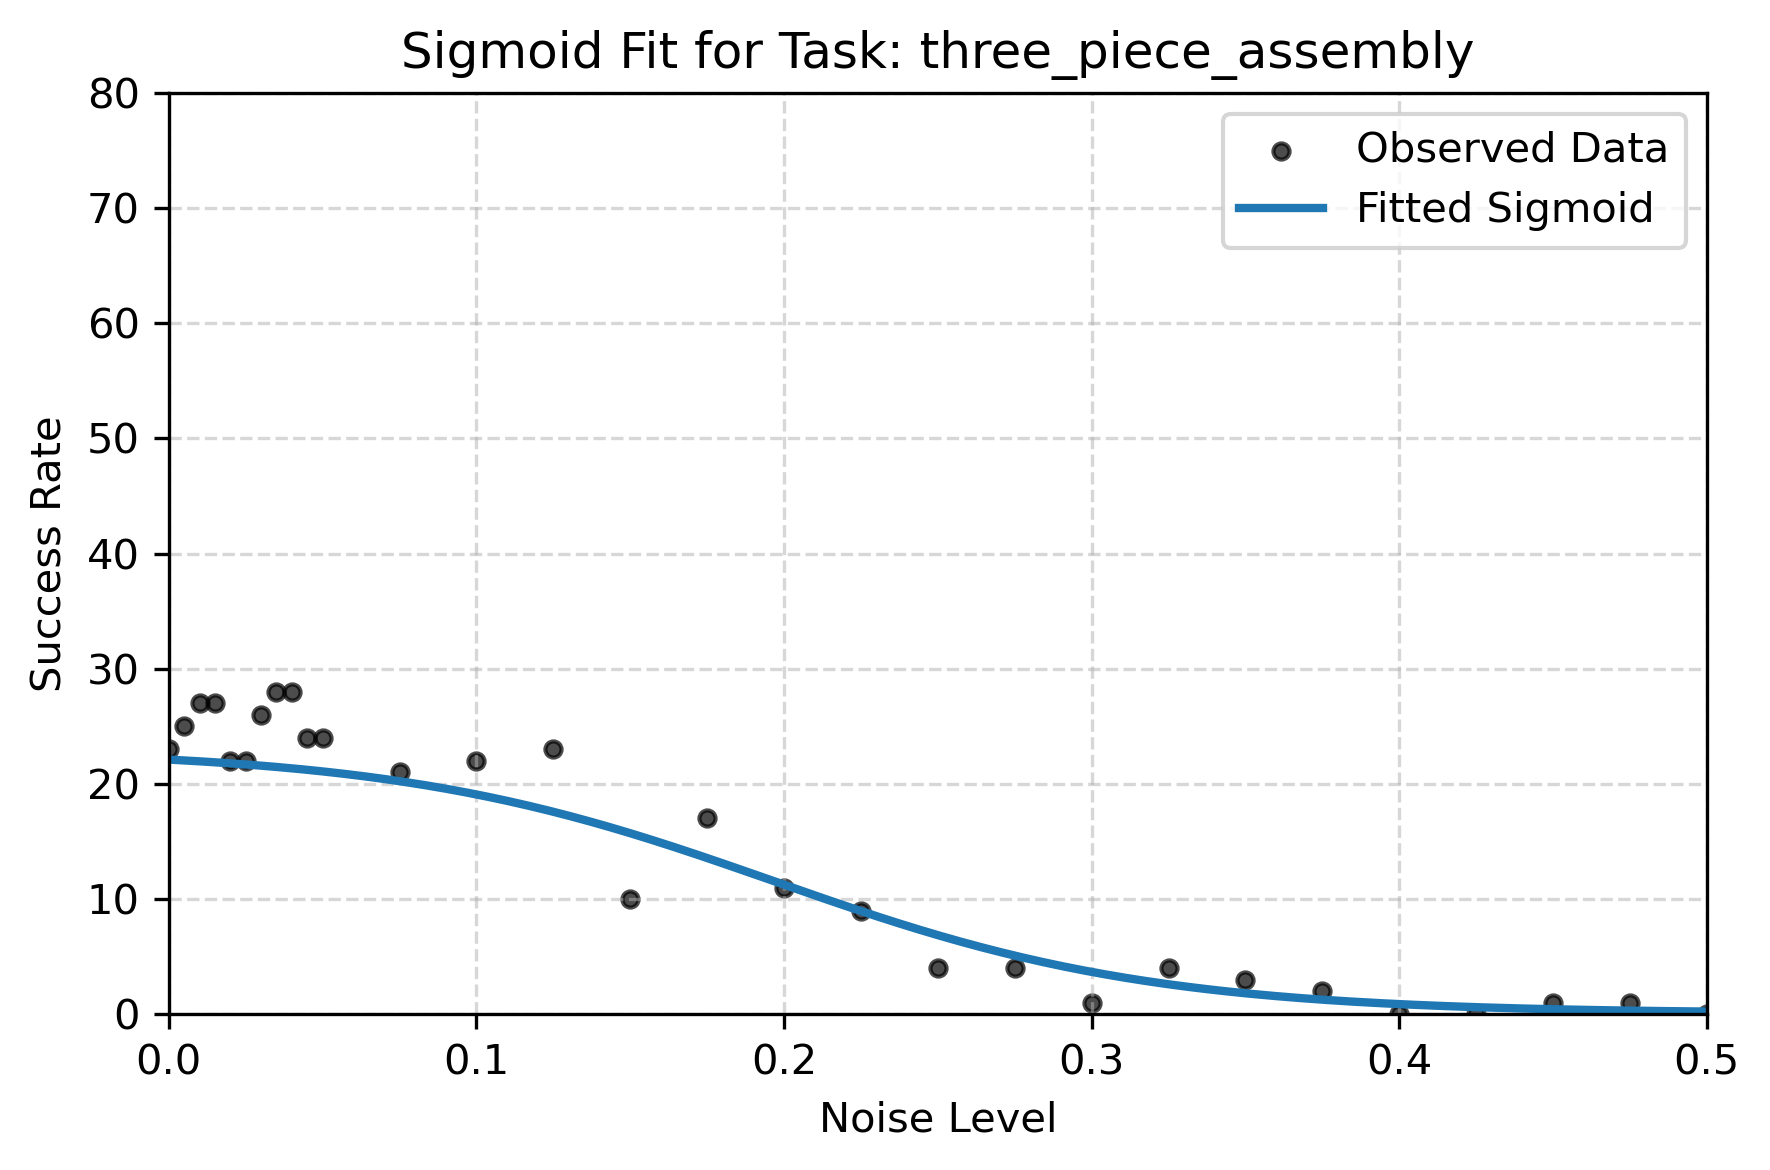

Fitted parameter models:
B(P) = 1.0006 + 0.0001 * P
C(P) = 15.0856 + 0.0525 * P
E(P) = -3.1341 + -0.0034 * P
SSE: 487.41075274733595


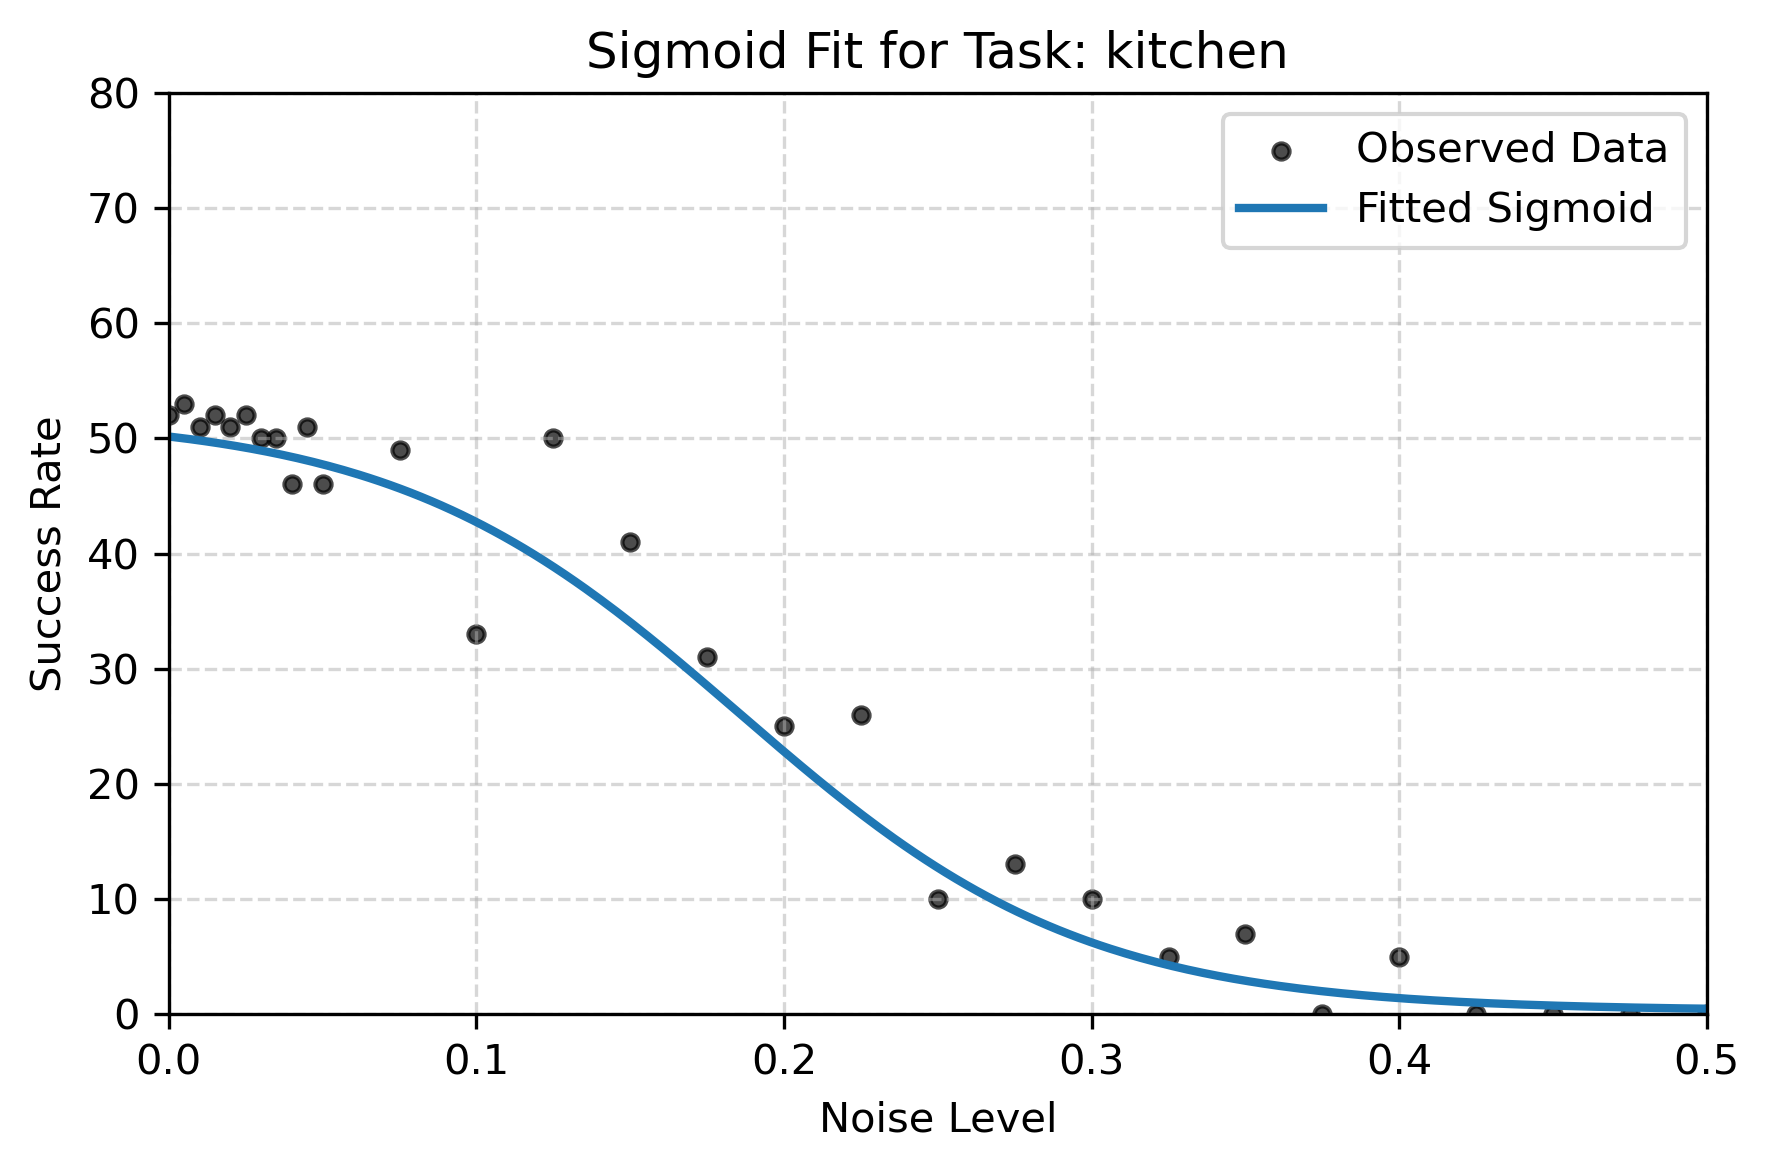

Fitted parameter models:
B(P) = 1.0006 + 0.0001 * P
C(P) = 15.0856 + 0.0525 * P
E(P) = -3.1341 + -0.0034 * P
SSE: 676.1674745088322


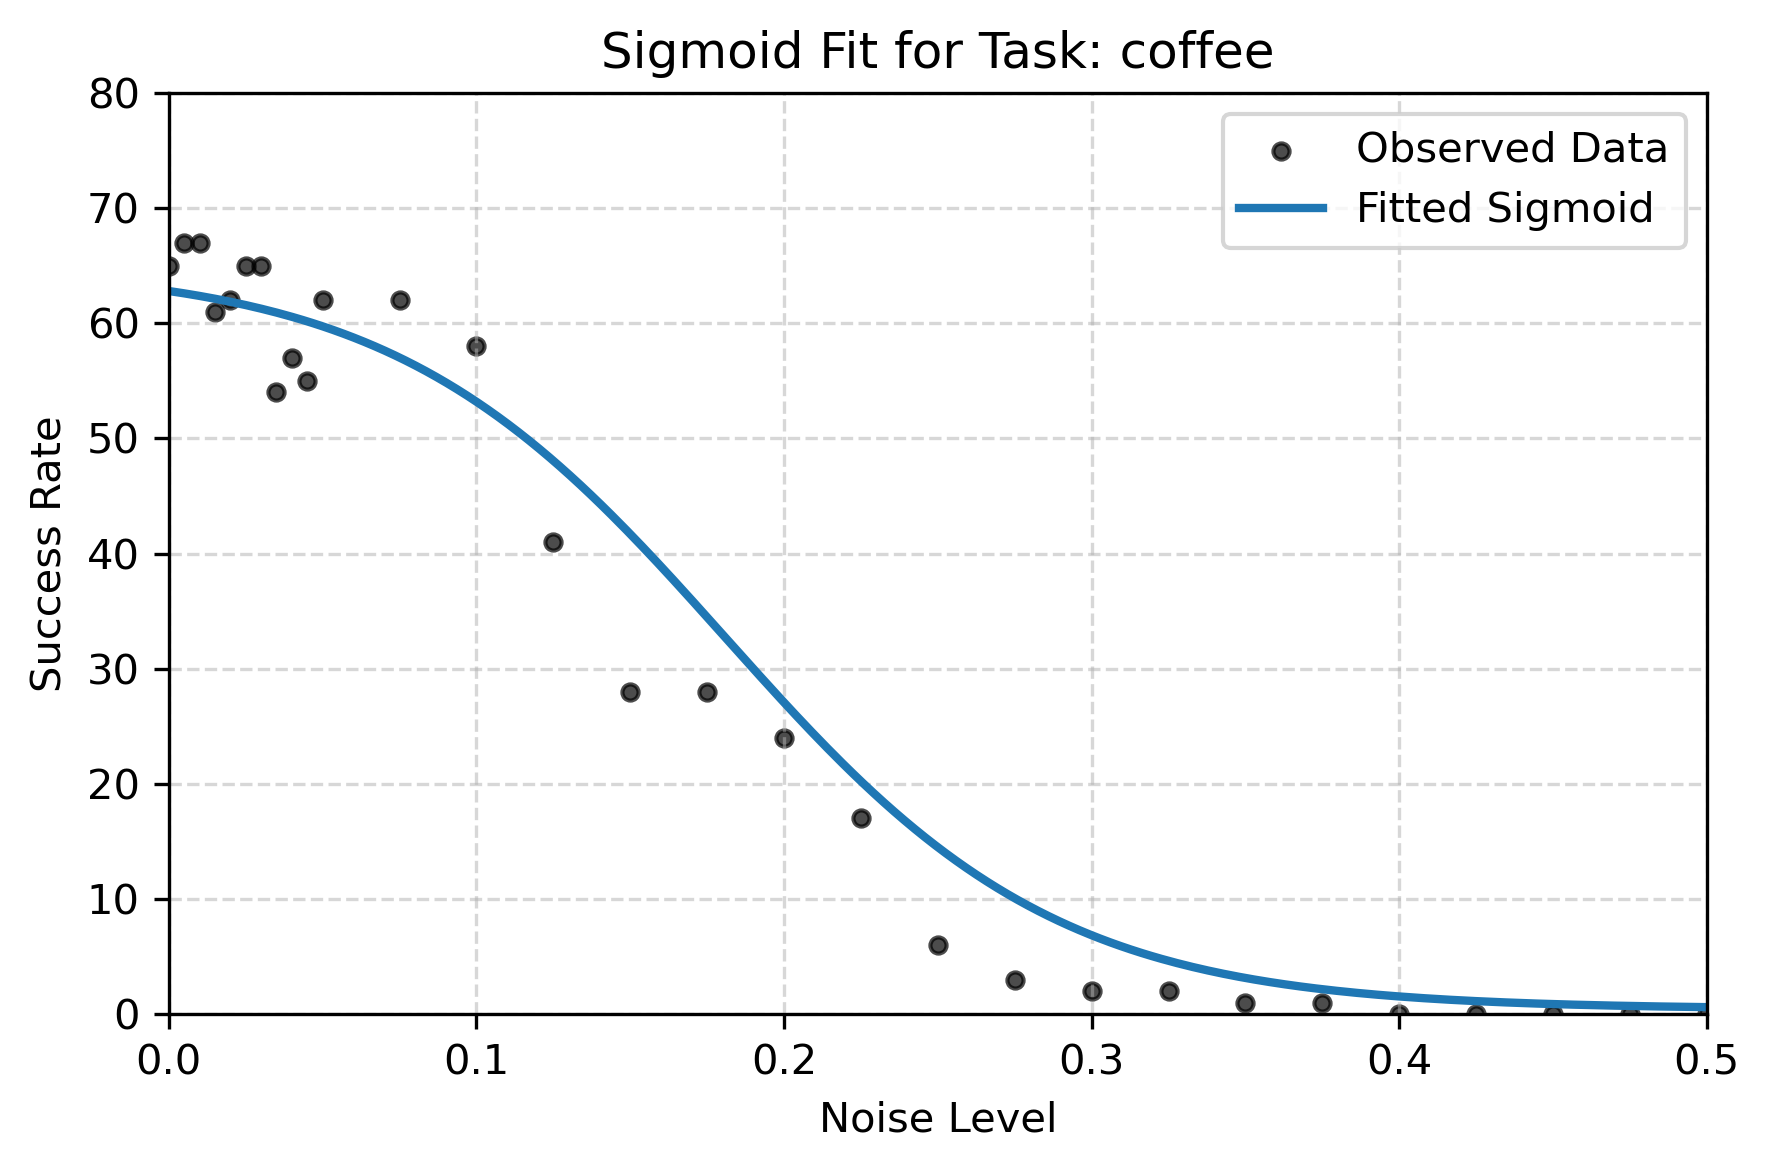

Fitted parameter models:
B(P) = 1.0006 + 0.0001 * P
C(P) = 15.0856 + 0.0525 * P
E(P) = -3.1341 + -0.0034 * P
SSE: 854.6048389693092


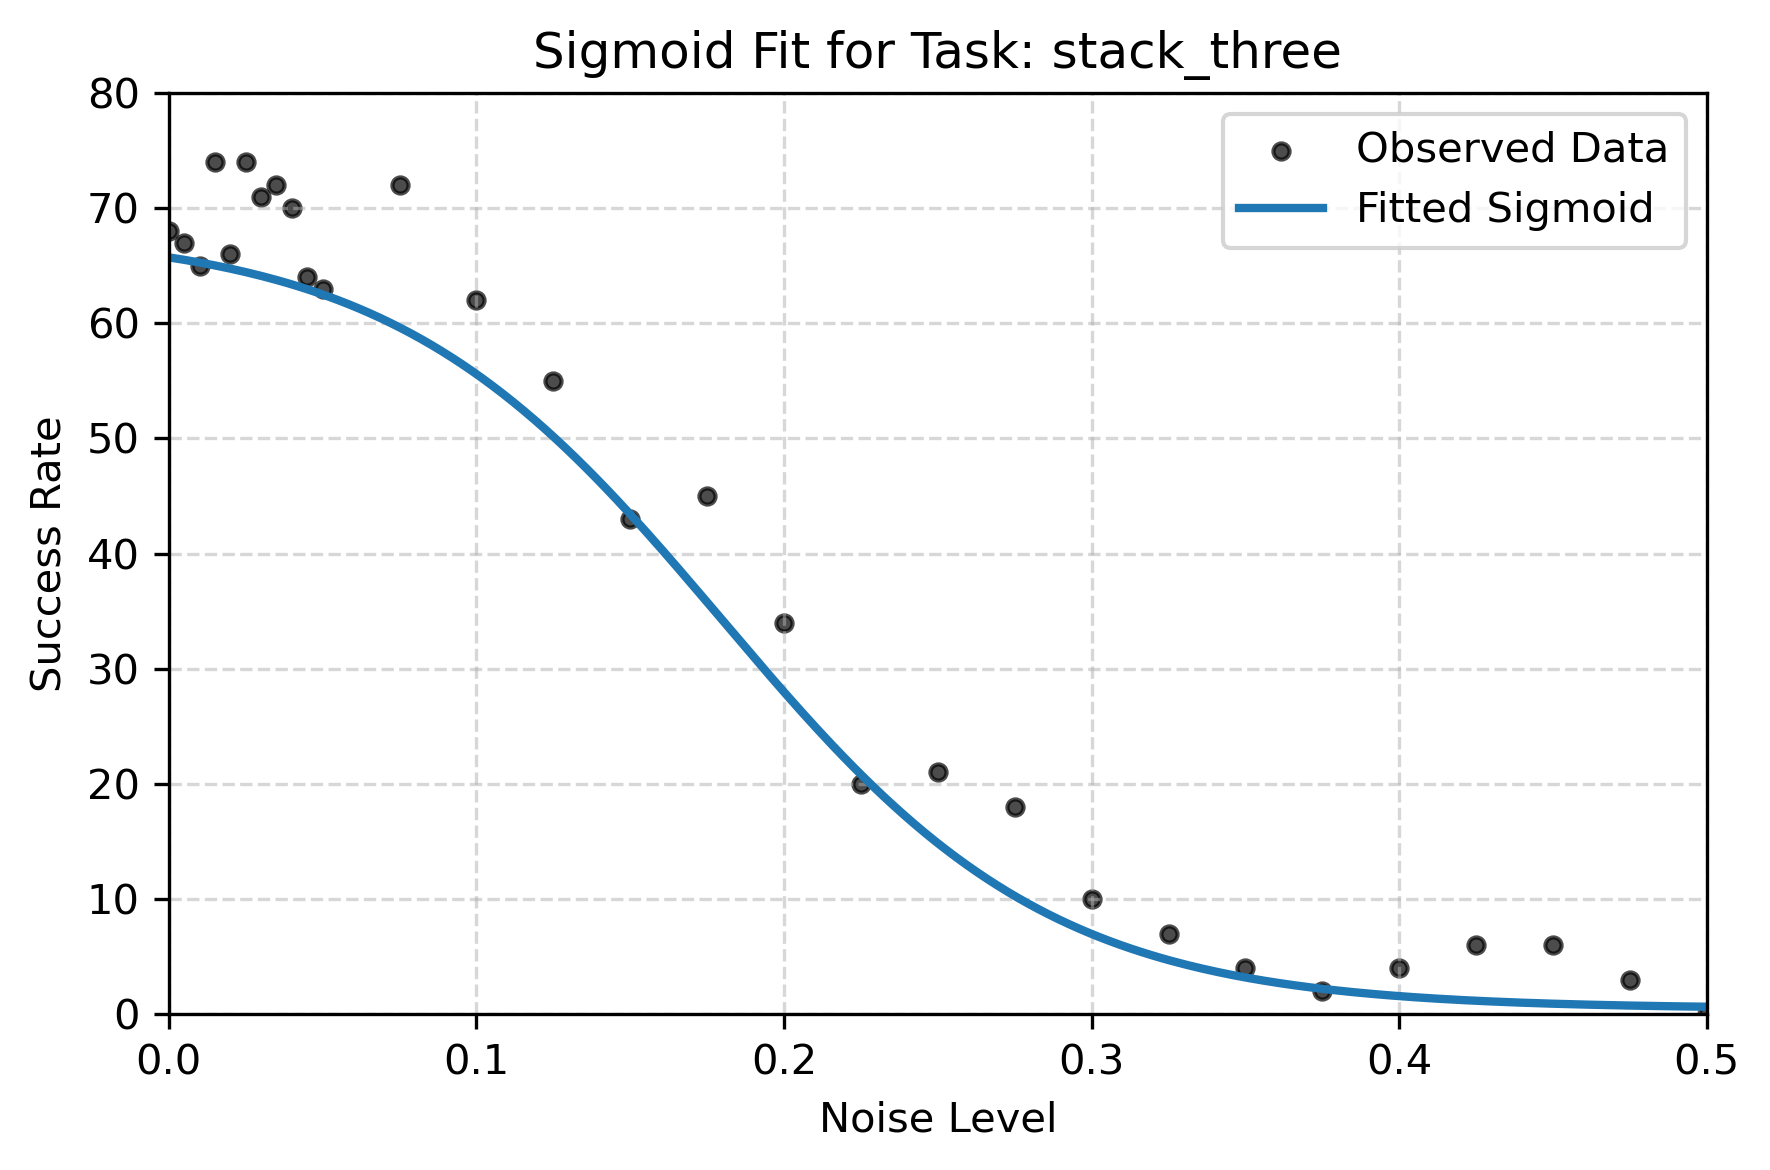

Fitted parameter models:
B(P) = 1.0006 + 0.0001 * P
C(P) = 15.0856 + 0.0525 * P
E(P) = -3.1341 + -0.0034 * P
SSE: 146.56224626089474


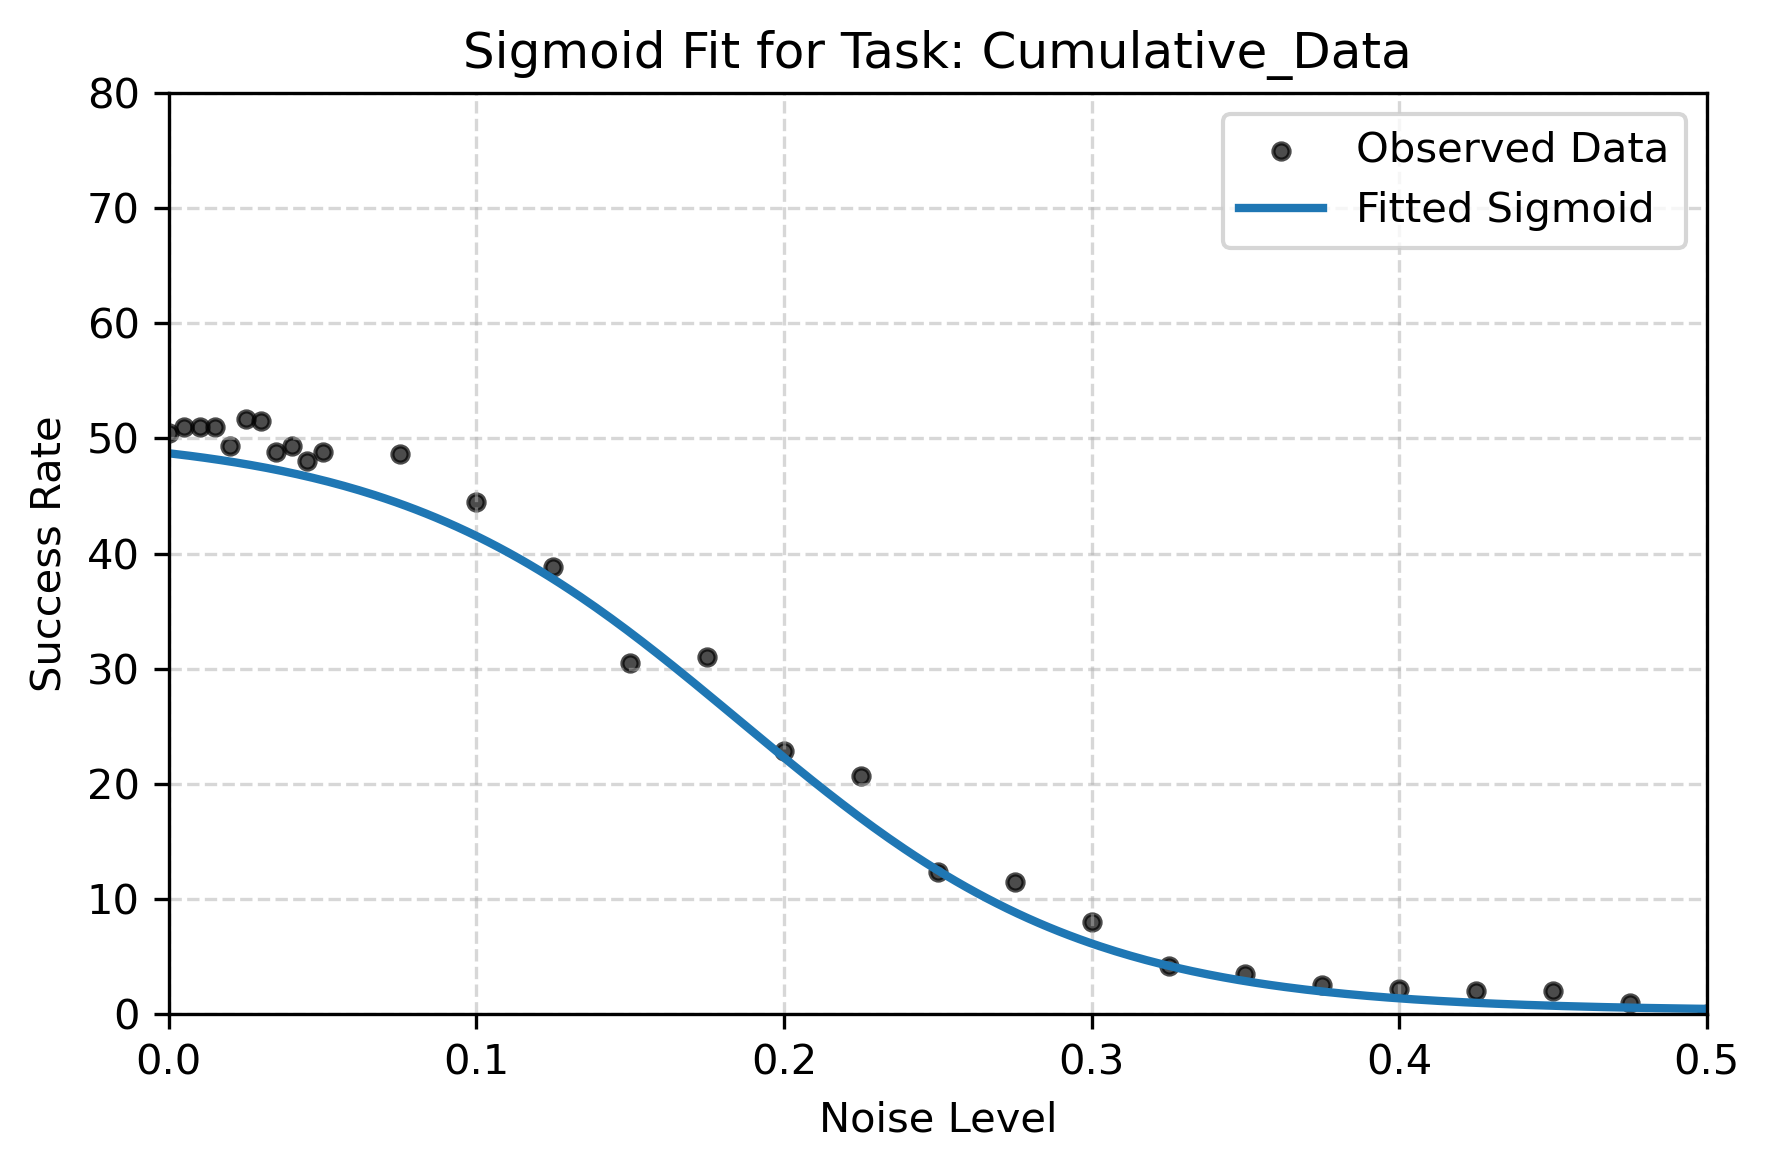

In [205]:
for task in tasks:
    data_dir = os.path.expanduser("~/MimicGenProject/MimicGenProject/data")
    output_csv = os.path.join(data_dir, f"{task}.csv")
    data = pd.read_csv(output_csv)
    data = data[data["noise"] < 1.0]

    # Your data
    x_data = data["noise"].to_numpy()
    y_data = data["success_rate"].to_numpy() if task != "Cumulative_Data" else data["avg accuracy"].to_numpy()

    P = y_data[0]

    # Your sigmoid function
    custom_sigmoid = fit_parameter_models(learned_parameters)

    # print(f"Parameters for task {task}: {str(params_opt)}")
    # print(f"Performance with 0 noise: {y_data[0]}")
    SSE = np.sum((y_data - custom_sigmoid(x_data, P))**2)
    print(f"SSE: {SSE}")
    # Put the SSE in the summary_statistics DataFrame
    summary_statistics.loc[task, 'SSE2'] = SSE
    # Add RMSE and MAE to summary_statistics
    RMSE = np.sqrt(SSE / len(x_data))
    MAE = np.mean(np.abs(y_data - custom_sigmoid(x_data, P)))
    summary_statistics.loc[task, 'RMSE2'] = RMSE
    summary_statistics.loc[task, 'MAE2'] = MAE
    # Add R^2 to summary_statistics
    y_mean = np.mean(y_data)
    SS_total = np.sum((y_data - y_mean)**2)
    SS_residual = np.sum((y_data - custom_sigmoid(x_data, P))**2)
    R_squared = 1 - (SS_residual / SS_total)
    summary_statistics.loc[task, 'R_squared2'] = R_squared
    
    # Plot
    plt.figure(figsize=(6, 4), dpi=300)
    plt.scatter(x_data, y_data, label='Observed Data', color='black', s=15, alpha=0.7)

    x_fit = np.linspace(min(x_data), max(x_data), 300)
    y_fit = custom_sigmoid(x_fit, P)
    plt.plot(x_fit, y_fit, label='Fitted Sigmoid', linewidth=2)

    # Labels and styling
    plt.title(f"Sigmoid Fit for Task: {task}", fontsize=12)
    plt.xlabel("Noise Level", fontsize=10)
    plt.ylabel("Success Rate", fontsize=10)
    plt.ylim(0,80)
    plt.xlim(0,.5)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    # Optional: save figure
    # fig_path = os.path.join(data_dir, f"{task}_fit.png")
    # plt.savefig(fig_path, dpi=300)

    plt.show()

In [206]:
statistics = summary_statistics.copy()
trial_count = 30
# Display summary statistics
print("Summary Statistics:")
print(statistics)

Summary Statistics:
                            SSE1         SSE2     RMSE1      MAE1  R_squared1  \
square                267.622802  1121.943912  3.037824  2.366566    0.963045   
nut_assembly          279.670012   373.939301  3.105446  2.304336    0.981436   
three_piece_assembly  145.067728   289.506569  2.236590  1.702745    0.956261   
kitchen               361.906033   487.410753  3.532636  2.373988    0.971973   
coffee                354.325808   676.167475  3.495444  2.602976    0.984119   
stack_three           336.957914   854.604839  3.408700  2.873784    0.985642   
Cumulative_Data        48.070585   146.562246  1.287481  0.969192    0.996167   

                         RMSE2      MAE2  R_squared2  
square                6.219945  4.556685    0.845074  
nut_assembly          3.590885  2.642779    0.975178  
three_piece_assembly  3.159586  2.390254    0.912712  
kitchen               4.099667  3.115771    0.962254  
coffee                4.828677  3.866028    0.969694  
s